<a href="https://colab.research.google.com/github/reshalfahsi/domain-adaptation/blob/master/Domain_Adaptation_With_Domain_Adversarial_Training_of_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Domain Adaptation With Domain-Adversarial Training of Neural Networks**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 162.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 146.3 MB/s eta 0:00:00


### **Import**

In [2]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import Accuracy

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torch.autograd import Function

from torchvision.transforms.v2 import (
    Compose,
    ToTensor,
    Resize,
    Lambda,
    RandomInvert,
    RandomAffine,
    RandomChannelPermutation,
    RandomPhotometricDistort
)
from torchvision.datasets import SVHN, VisionDataset
from torchvision.datasets.utils import (
    _flip_byte_order,
    check_integrity,
    download_url,
    download_and_extract_archive
)
from torchvision.models import (
    regnet_y_400mf,
    RegNet_Y_400MF_Weights
)

from urllib.error import URLError

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from PIL import Image

from functools import partial

import codecs

import os
import sys
import cv2
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
EPOCH = 50
NUM_CLASSES = 10
LEARNING_RATE = 1e-3
BASE_LR_SCALE = 1e-4
EARLY_STOPPING_PATIENCE = 1e-1

In [4]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE       = "max"

In [5]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [6]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1500186762


## **Dataset**

### **Utils**

In [7]:
TRANSFORM = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)
TRANSFORM_AUGMENTATION = Compose(
    [
        RandomAffine(
            degrees=90.,
            translate=(0.1, 0.1),
            scale=(0.69, 1.414),
            shear=10.,
        ),
        RandomInvert(),
        RandomPhotometricDistort(),
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        RandomChannelPermutation(),
        ToTensor(),
        Lambda(lambda x: (x * 2) - 1),
    ]
)

In [8]:
def get_int(b: bytes) -> int:
    return int(codecs.encode(b, "hex"), 16)

In [9]:
SN3_PASCALVINCENT_TYPEMAP = {
    8: torch.uint8,
    9: torch.int8,
    11: torch.int16,
    12: torch.int32,
    13: torch.float32,
    14: torch.float64,
}

In [10]:
def read_sn3_pascalvincent_tensor(
    path: str,
    strict: bool = True,
) -> torch.Tensor:
    """Read a SN3 file in "Pascal Vincent" format
    (Lush file 'libidx/idx-io.lsh'). Argument may be a filename,
    compressed filename, or file object.
    """
    # read
    with open(path, "rb") as f:
        data = f.read()

    # parse
    if sys.byteorder == "little":
        magic = get_int(data[0:4])
        nd = magic % 256
        ty = magic // 256
    else:
        nd = get_int(data[0:1])
        ty = (
            get_int(data[1:2])
            + get_int(data[2:3]) * 256
            + get_int(data[3:4]) * 256 * 256
        )

    assert 1 <= nd <= 3
    assert 8 <= ty <= 14
    torch_type = SN3_PASCALVINCENT_TYPEMAP[ty]
    s = [get_int(data[4 * (i + 1) : 4 * (i + 2)]) for i in range(nd)]

    if sys.byteorder == "big":
        for i in range(len(s)):
            s[i] = int.from_bytes(
                s[i].to_bytes(4, byteorder="little"),
                byteorder="big",
                signed=False,
            )

    parsed = torch.frombuffer(
        bytearray(data), dtype=torch_type, offset=(4 * (nd + 1))
    )

    # The MNIST format uses the big endian byte order, while `torch.frombuffer`
    # uses whatever the system uses. In case that is little endian and the dtype
    # has more than one byte, we need to flip them.
    if sys.byteorder == "little" and parsed.element_size() > 1:
        parsed = _flip_byte_order(parsed)

    assert parsed.shape[0] == np.prod(s) or not strict
    return parsed.view(*s)

In [11]:
def read_image_file(path: str) -> torch.Tensor:
    x = read_sn3_pascalvincent_tensor(path, strict=False)
    if x.dtype != torch.uint8:
        raise TypeError(
            f"x should be of dtype torch.uint8 instead of {x.dtype}"
        )
    if x.ndimension() != 3:
        raise ValueError(
            f"x should have 3 dimension instead of {x.ndimension()}"
        )
    return x

In [12]:
def read_label_file(path: str) -> torch.Tensor:
    x = read_sn3_pascalvincent_tensor(path, strict=False)
    if x.dtype != torch.uint8:
        raise TypeError(
            f"x should be of dtype torch.uint8 instead of {x.dtype}"
        )
    if x.ndimension() != 1:
        raise ValueError(
            f"x should have 1 dimension instead of {x.ndimension()}"
        )
    return x.long()

In [13]:
class DomainAdaptationDataset(VisionDataset):
    mirrors = [
        "http://yann.lecun.com/exdb/mnist/",
        "https://ossci-datasets.s3.amazonaws.com/mnist/",
    ]

    resources = [
        ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
    ]

    split_list = [
        "http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
        "train_32x32.mat",
        "e26dedcc434d2e4c54c9b2d4a06d8373",
    ]

    def __init__(self, root: str) -> None:
        super().__init__(root)

        self.url = self.split_list[0]
        self.filename = self.split_list[1]
        self.file_md5 = self.split_list[2]

        self.download_mnist()
        self.download_svhn()

        if not self._check_exists_mnist and not self._check_integrity_svhn:
            raise RuntimeError(
                "Dataset not found. You can use download=True to download it"
            )

        self.data_mnist, self.labels_mnist = self._load_data_mnist()

        loaded_mat = sio.loadmat(os.path.join(self.root, self.filename))
        self.data_svhn = np.transpose(loaded_mat["X"], (3, 2, 0, 1))

    def _load_data_mnist(self):
        image_file = f"train-images-idx3-ubyte"
        data = read_image_file(os.path.join(self.raw_folder, image_file))

        label_file = f"train-labels-idx1-ubyte"
        targets = read_label_file(os.path.join(self.raw_folder, label_file))

        return data, targets

    def __getitem__(self, index: int):
        index_mnist = (
            index % len(self.data_mnist)
            if index > (len(self.data_mnist) - 1)
            else index
        )
        img_mnist = self.data_mnist[index_mnist]
        img_svhn = self.data_svhn[index]

        label_mnist = int(self.labels_mnist[index_mnist])

        img_mnist = Image.fromarray(img_mnist.numpy(), mode="L").convert("RGB")
        img_svhn = Image.fromarray(np.transpose(img_svhn, (1, 2, 0)))

        img_mnist = TRANSFORM_AUGMENTATION(img_mnist)
        img_svhn = TRANSFORM(img_svhn)

        return img_mnist, img_svhn, label_mnist

    def __len__(self) -> int:
        return len(self.data_svhn)

    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "raw")

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "processed")

    @property
    def _check_exists_mnist(self) -> bool:
        return all(
            check_integrity(
                os.path.join(
                    self.raw_folder, os.path.splitext(os.path.basename(url))[0]
                )
            )
            for url, _ in self.resources
        )

    @property
    def _check_integrity_svhn(self) -> bool:
        return check_integrity(
            os.path.join(self.root, self.filename),
            self.file_md5,
        )

    def download_svhn(self) -> None:
        if self._check_integrity_svhn:
            return

        download_url(self.url, self.root, self.filename, self.file_md5)

    def download_mnist(self) -> None:
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists_mnist:
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = f"{mirror}{filename}"
                try:
                    print(f"Downloading {url}")
                    download_and_extract_archive(
                        url,
                        download_root=self.raw_folder,
                        filename=filename,
                        md5=md5,
                    )
                except URLError as error:
                    print(f"Failed to download (trying next):\n{error}")
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError(f"Error downloading {filename}")

### **Load**

In [14]:
TrainDataset = DomainAdaptationDataset(root="experiment/dataset")
ValDataset = SVHN(
    root="experiment/dataset",
    split="test",
    transform=TRANSFORM,
    download=True,
)
TestDataset = ValDataset

100%|██████████| 9912422/9912422 [00:00<00:00, 419664186.01it/s]

Extracting experiment/dataset/DomainAdaptationDataset/raw/train-images-idx3-ubyte.gz to experiment/dataset/DomainAdaptationDataset/raw


100%|██████████| 28881/28881 [00:00<00:00, 30095824.55it/s]

Extracting experiment/dataset/DomainAdaptationDataset/raw/train-labels-idx1-ubyte.gz to experiment/dataset/DomainAdaptationDataset/raw



100%|██████████| 182040794/182040794 [00:45<00:00, 3966788.33it/s]


100%|██████████| 64275384/64275384 [00:15<00:00, 4178314.30it/s]


## **Utils**

In [15]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

## **Model**

In [16]:
class GradientReversalLayer(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg()
        return output, None

In [17]:
class DANN(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.backbone = regnet_y_400mf(
            weights=RegNet_Y_400MF_Weights.DEFAULT,
        )
        self.backbone.fc = nn.Sequential(
            nn.Linear(440, 110, bias=False),
            nn.BatchNorm1d(110),
            nn.ReLU(True),
            nn.Dropout(p=0.4),
            nn.Linear(110, 110, bias=False),
            nn.BatchNorm1d(110),
            nn.ReLU(True),
            nn.Dropout(p=0.4),
            nn.Linear(110, 10),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(440, 110, bias=False),
            nn.BatchNorm1d(110),
            nn.ReLU(True),
            nn.Dropout(p=0.4),
            nn.Linear(110, 2),
        )

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.val_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.test_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        x = self.backbone.stem(x)
        x = self.backbone.trunk_output(x)

        x = self.backbone.avgpool(x)
        x = x.flatten(start_dim=1)

        x_class = self.backbone.fc(x)

        if not self.training:
            return x_class

        x_reverse = GradientReversalLayer.apply(x)
        x_domain = self.domain_classifier(x_reverse)

        return x_class, x_domain

    def training_step(self, batch, batch_nb):
        source_images, target_images, source_labels = batch

        source_labels = source_labels.view(source_labels.shape[0])

        class_predictions, domain_predictions = self(source_images)

        self.train_accuracy.update(class_predictions.softmax(1), source_labels)
        acc = self.train_accuracy.compute().data.cpu()

        domain_labels = torch.zeros(
            source_images.size(0)
        ).long().to(self.device)

        class_loss = F.cross_entropy(class_predictions, source_labels)
        source_domain_loss = F.cross_entropy(domain_predictions, domain_labels)

        domain_labels = torch.ones(
            source_images.size(0)
        ).long().to(self.device)

        _, domain_predictions = self(target_images)
        target_domain_loss = F.cross_entropy(domain_predictions, domain_labels)

        opt = self.optimizers()
        opt.zero_grad()
        loss = (
            class_loss
            + source_domain_loss
            + target_domain_loss
        )
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        sch = self.lr_schedulers()
        sch.step()

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy()
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = (
            f"experiment/training/{MODEL_NAME}_loss_plot.png"
        )
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = (
            f"experiment/training/{MODEL_NAME}_acc_plot.png"
        )
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CyclicLR(
                optimizer,
                base_lr=BASE_LR_SCALE * self.lr,
                max_lr=self.lr,
                cycle_momentum=False,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [18]:
MODEL = DANN
MODEL_NAME = DANN.__name__
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

INFO: Seed set to 1500186762
INFO:lightning.fabric.utilities.seed:Seed set to 1500186762


DANN


Downloading: "https://download.pytorch.org/models/regnet_y_400mf-e6988f5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-e6988f5f.pth
100%|██████████| 16.8M/16.8M [00:01<00:00, 9.65MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type               | Params
---------------------------------------------------------
0 | backbone          | RegNet             | 4.0 M 
1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00036656334999999983 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007330267 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00090050995 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0005340465999999997 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00016758325 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00019908009999999984 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00056554345 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0009320068000000003 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007015298499999993 - Epoch: 8


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0003350665 - Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 3.1596850000000304e-05 - Epoch: 10


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0003980601999999997 - Epoch: 11


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007645235499999999 - Epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0008690130999999997 - Epoch: 13


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0005025497500000003 - Epoch: 14


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0001360864000000001 - Epoch: 15


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00023057694999999926 - Epoch: 16


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0005970403000000013 - Epoch: 17


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0009635036499999997 - Epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0006700329999999999 - Epoch: 19


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00030356964999999963 - Epoch: 20


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 6.30937000000006e-05 - Epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0004295570500000009 - Epoch: 22


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007960203999999993 - Epoch: 23


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0008375162500000003 - Epoch: 24


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00047105290000000005 - Epoch: 25


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00010458954999999982 - Epoch: 26


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00026207380000000047 - Epoch: 27


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0006285371500000007 - Epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0009950004999999993 - Epoch: 29


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0006385361500000005 - Epoch: 30


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0002720728000000002 - Epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 9.459055000000003e-05 - Epoch: 32


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00046105390000000026 - Epoch: 33


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0008275172500000005 - Epoch: 34


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0008060193999999991 - Epoch: 35


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00043955605000000063 - Epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 7.30927000000004e-05 - Epoch: 37


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00029357065000000163 - Epoch: 38


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0006600340000000001 - Epoch: 39


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0009735026500000013 - Epoch: 40


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0006070392999999992 - Epoch: 41


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00024057595000000082 - Epoch: 42


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0001260874000000012 - Epoch: 43


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0004925507499999996 - Epoch: 44


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0008590141000000017 - Epoch: 45


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007745225499999997 - Epoch: 46


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00040805920000000127 - Epoch: 47


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 4.15958499999992e-05 - Epoch: 48


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00032506749999999926 - Epoch: 49


INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


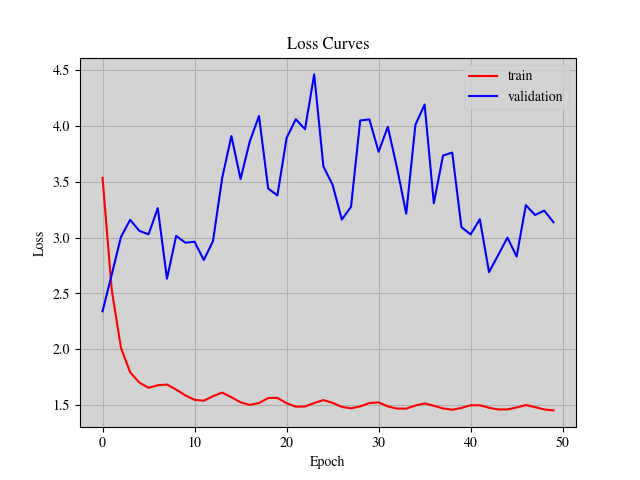

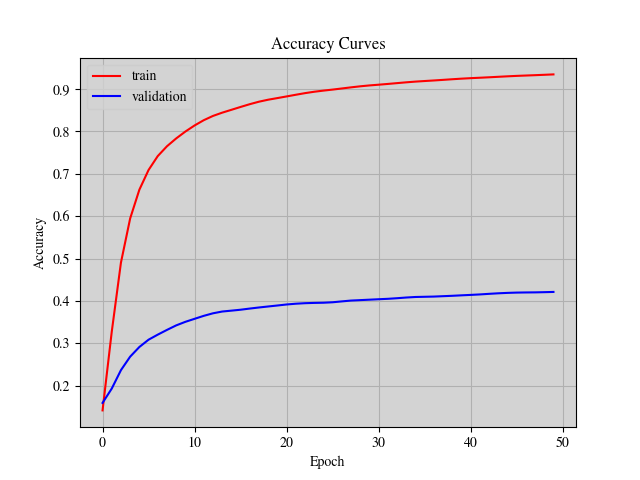

<Figure size 640x480 with 0 Axes>

In [19]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)
    model = MODEL()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=int(
            EARLY_STOPPING_PATIENCE * EPOCH
        ),
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [20]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/DANN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/DANN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/DANN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint 

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4478934109210968     │
│         test_loss         │     3.137967824935913     │
└───────────────────────────┴───────────────────────────┘

## **Inference**

Using downloaded and verified file: experiment/dataset/test_32x32.mat


<Figure size 640x480 with 0 Axes>

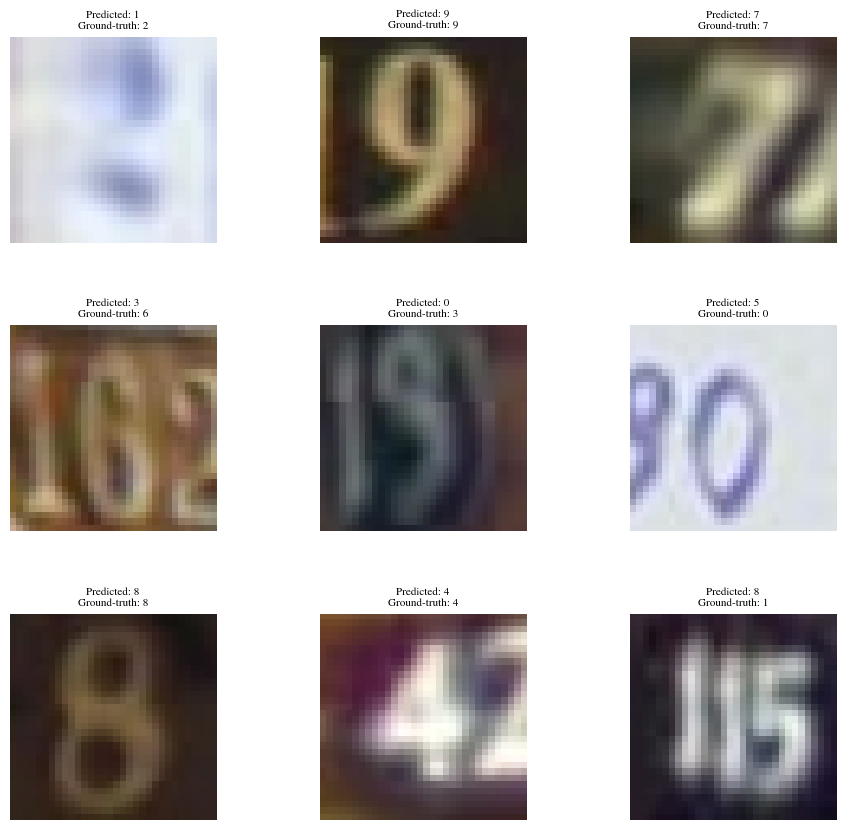

In [21]:
model = MODEL.load_from_checkpoint(
    BEST_MODEL_PATH
)
model.eval()

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

class_bin = list()

InferenceDataset = SVHN(
    root='experiment/dataset/',
    split="test",
    download=True,
)

for index in range(9):
    while True:
        sample_idx = random.randint(0, len(InferenceDataset) - 1)
        image, gt_class = InferenceDataset[sample_idx]

        if not gt_class in class_bin:
            class_bin.append(gt_class)
            break
        else:
            continue

    prediction = model(
        TRANSFORM(image).to(
            "cuda" if torch.cuda.is_available else "cpu"
        ).unsqueeze(0),
    )

    prediction.softmax(1)
    predicted_class = torch.argmax(prediction).data.cpu().numpy()

    title = f"Predicted: {predicted_class}\n"
    title += f"Ground-truth: {gt_class}"

    ax = fig.add_subplot(3, 3, index + 1)

    ax.imshow(np.array(image).astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

del InferenceDataset